![Instacart](https://raw.githubusercontent.com/interviewquery/takehomes/instacart_1/instacart_1/logo.png)
# Data Analyst Challenge

## Directions

We'd love for you to analyze the data in `data.csv` and share what you find. We know
that you don't know much about how our team currently is run, but that's
okay. This data set includes information on orders, order location,
customer ratings, and any issues reported by the customer for a set of
orders.

1. Please analyze the data in the adjacent tab and share with us the

    1. any observations about our business.

    1. How would you staff the Customer Support Team?

Please compile your analysis into a document or deck to convey your
findings. Use the Data Set as necessary to substantiate your claims.


In [52]:
!git clone --branch instacart_1 https://github.com/interviewquery/takehomes.git
%cd takehomes/instacart_1
!ls

Cloning into 'takehomes'...
remote: Enumerating objects: 1968, done.
remote: Counting objects: 100% (1968/1968), done.
remote: Compressing objects: 100% (1222/1222), done.
remote: Total 1968 (delta 755), reused 1933 (delta 729), pack-reused 0 (from 0)
Receiving objects: 100% (1968/1968), 299.41 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (755/755), done.
/content/takehomes/instacart_1/takehomes/instacart_1
data.csv  logo.png  metadata.json  takehomefile.ipynb


In [53]:
#write your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
df=pd.read_csv('data.csv')

**整体思路**：先看单一指标 → 再做关联探索 → 再结合业务价值排序 → 最后提出可执行建议（staffing、SLA、CX改进等）
## SQL
Use SQL to read data, constructing next steps useful for business inisghts.

In [55]:
# !pip install sqlalchemy
from sqlalchemy import create_engine

In [56]:
engine = create_engine("sqlite:///customer_data.sqlite")

df.to_sql("customer_data", engine, if_exists="replace", index=False)
df_query = pd.read_sql("SELECT * FROM customer_data", engine)

In [57]:
df_query

,order delivery time,order id,customer order rating,type of issue reported,region
0,2014-06-02 04:23:16 UTC,233599337,5,None,chi
1,2014-06-02 03:57:50 UTC,233599376,5,None,chi
2,2014-06-02 02:52:38 UTC,233599328,5,None,chi
3,2014-06-02 02:52:04 UTC,233599070,5,None,chi
4,2014-06-02 02:41:43 UTC,233599100,5,None,chi
...,...,...,...,...,...
14952,2014-05-07 20:29:32 +0000,233614661,0,None,sf
14953,2014-05-05 23:59:17 +0000,233614666,0,None,sf
14954,2014-05-04 22:48:29 +0000,233614671,0,None,sf
14955,2014-05-03 17:41:36 +0000,233614676,0,None,sf


In [58]:
distinct_regions_df = pd.read_sql("SELECT DISTINCT region FROM customer_data", engine)
display(distinct_regions_df)

,region
0,chi
1,nyc
2,sf
3,sf


发现sf数据重复，因为有space的差别，做数据清洗修正这个错误

‼️是否有其他更好/常规的方法来做这步？

In [59]:
# Clean the 'region' column by stripping whitespace
df['region'] = df['region'].str.strip()

# Update the SQL table with the cleaned data
df.to_sql("customer_data", engine, if_exists="replace", index=False)

# Now, let's check the distinct regions again after cleaning
query_distinct_regions_cleaned = """
SELECT DISTINCT region FROM customer_data;
"""
distinct_regions_cleaned_df = pd.read_sql(query_distinct_regions_cleaned, engine)
display(distinct_regions_cleaned_df)

,region
0,chi
1,nyc
2,sf


In [60]:
query = """
SELECT `order id`, count(`order id`) as count, region
FROM customer_data
GROUP BY `order id`
ORDER BY count DESC
"""
OrderId_df = pd.read_sql(query, engine)
display(OrderId_df)

,order id,count,region
0,233598760,6,chi
1,246371,6,sf
2,237775,6,nyc
3,228263,5,sf
4,226403,5,sf
...,...,...,...
13840,215936,1,chi
13841,215925,1,sf
13842,214101,1,nyc
13843,214084,1,nyc


In [61]:
# 看不同地区的使用频率
distribution_by_region_and_order_count = OrderId_df.groupby(['region', 'count']).size().reset_index(name='occurrence')

display(distribution_by_region_and_order_count)

,region,count,occurrence
0,chi,1,5577
1,chi,2,343
2,chi,3,47
3,chi,4,5
4,chi,6,1
5,nyc,1,1132
6,nyc,2,59
7,nyc,3,6
8,nyc,4,4
9,nyc,6,1


In [62]:
query = """
SELECT `customer order rating` as rating, count(`customer order rating`) as count
FROM customer_data
GROUP BY `customer order rating`
ORDER BY rating DESC
"""
rating_df = pd.read_sql(query, engine)
display(rating_df)

,rating,count
0,5,11602
1,4,1680
2,3,778
3,2,370
4,1,373
5,0,154


#### distribution of customer order ratings and their respective proportions:

In [63]:
# Calculate the total count of all ratings
total_ratings = rating_df['count'].sum()

# Calculate the proportion for each rating
rating_df['proportion'] = rating_df['count'] / total_ratings

display(rating_df)

,rating,count,proportion
0,5,11602,0.775690
1,4,1680,0.112322
2,3,778,0.052016
3,2,370,0.024738
4,1,373,0.024938
5,0,154,0.010296


77.5%的5星好评率 -> 并不算高  
差评率（<= 3星）-> 约等于6%

In [64]:
query = """
SELECT MIN(`order delivery time`) AS earliest_delivery_time,
       MAX(`order delivery time`) AS latest_delivery_time
FROM customer_data
"""
time_range_df = pd.read_sql(query, engine)
display(time_range_df)

,earliest_delivery_time,latest_delivery_time
0,2014-05-01 08:54:00 +0000,2014-06-02 06:28:37 +0000


In [65]:
query = """
SELECT `type of issue reported`, COUNT(*) as count
FROM customer_data
GROUP BY `type of issue reported`
ORDER BY count DESC
"""
issue_counts_df = pd.read_sql(query, engine)
display(issue_counts_df)

,type of issue reported,count
0,None,13870
1,Wrong item,374
2,Damaged or spoiled,310
3,Item missing,178
4,Poor service,129
5,Poor replacement,54
6,Other Order Issue,21
7,Item charged incorrectly,21


#### distribution of reported issue types and their respective proportions:

In [66]:
# Calculate the total count of all issues
total_issues = issue_counts_df['count'].sum()

# Calculate the proportion for each issue type
issue_counts_df['proportion'] = issue_counts_df['count'] / total_issues

display(issue_counts_df)

,type of issue reported,count,proportion
0,None,13870,0.927325
1,Wrong item,374,0.025005
2,Damaged or spoiled,310,0.020726
3,Item missing,178,0.011901
4,Poor service,129,0.008625
5,Poor replacement,54,0.003610
6,Other Order Issue,21,0.001404
7,Item charged incorrectly,21,0.001404


- 92.7%无事发生
- 产品问题：wrong item + damaged/spoiled + item missing -> 占比5.7%  
- 服务问题：poor service + poor replacement -> 1.2%  
- logistical issue: item charged incoorectly -> 0.1%  
由此可知，重点首先应放在提升产品本身上，也就是和商家之间的沟通和选择更优质的商家

## Now look into relationships
### Customer Rating Distribution - Rating as Measurement

#### Rating & Region

In [67]:
query = """
SELECT region AS Region, AVG(`customer order rating`) AS Average_Rating, COUNT(*) AS Count
FROM customer_data
GROUP BY `region`
ORDER BY `Average_Rating` DESC
"""
rating_region_df = pd.read_sql(query, engine)
display(rating_region_df)

,Region,Average_Rating,Count
0,chi,4.711820,6430
1,sf,4.444383,7237
2,nyc,4.431008,1290


**Takeaway**: 三个地区的平均分数没有差很多，其中chi (Chicago?)可以尤其注意，做的好的地方，因为这个区域的评分又高，订单量又多（当然，订单量最好是和人口/目标客群的比值来比最有效）

**不同地区，消费不同次数（count）的人的个数（occurrence）和与之对应的average_rating**

In [68]:
# Calculate the average rating for each unique order_id from the original data
order_id_ratings = df.groupby('order id')['customer order rating'].mean().reset_index()
order_id_ratings.rename(columns={'customer order rating': 'average_rating_per_order'}, inplace=True)

# Merge OrderId_df with order_id_ratings to bring in the 'average_rating_per_order' for each order_id
OrderId_df_with_ratings = pd.merge(OrderId_df, order_id_ratings, on='order id', how='left')

# Now, group this new DataFrame by 'region' and 'count' and calculate the average of 'average_rating_per_order'
distribution_by_region_and_order_count = OrderId_df_with_ratings.groupby(['region', 'count']).agg(
    occurrence=('order id', 'size'),  # Keep the original 'occurrence' logic (number of order_ids in this group)
    average_rating=('average_rating_per_order', 'mean') # Add the average rating for orders in this group
).reset_index()

display(distribution_by_region_and_order_count)

,region,count,occurrence,average_rating
0,chi,1,5577,4.759190
1,chi,2,343,4.558309
2,chi,3,47,4.000000
3,chi,4,5,2.900000
4,chi,6,1,1.000000
5,nyc,1,1132,4.555654
6,nyc,2,59,3.838983
7,nyc,3,6,3.166667
8,nyc,4,4,1.937500
9,nyc,6,1,3.000000


‼️这个数据就非常奇怪了，消费的多，评分怎么还低？

或许是因为我理解错了order id的意思？order id的意思是每一单，所以count对应的是每一单的物品数量而非一个月同一个人消费的总次数？

#### Rating & Type of Issue Reported

In [69]:
query = """
SELECT `type of issue reported`, AVG(`customer order rating`) AS Average_Rating, COUNT(*) AS Count
FROM customer_data
GROUP BY `type of issue reported`
ORDER BY `Average_Rating` DESC
"""
rating_issue_df = pd.read_sql(query, engine)
display(rating_issue_df)

,type of issue reported,Average_Rating,Count
0,None,4.683345,13870
1,Item charged incorrectly,4.190476,21
2,Other Order Issue,3.190476,21
3,Wrong item,3.144385,374
4,Damaged or spoiled,2.925806,310
5,Item missing,2.915730,178
6,Poor service,2.542636,129
7,Poor replacement,2.481481,54


这条可以看出哪些地方做的特别不好容易导致差评，对那些count多+评分低的项要尤其注意，应第一时间改进。如damaged, missing, poor service这种情况。特别是poor service因为这个是我方比较可控的。

#### Rating & Time

In [70]:
query_hourly_metrics = """
SELECT
    STRFTIME('%H', REPLACE(REPLACE(`order delivery time`, ' UTC', ''), ' +0000', '')) AS Hour_of_Day,
    COUNT(`order id`) AS Orders_Count,
    AVG(`customer order rating`) AS Average_Rating
FROM
    customer_data
GROUP BY
    Hour_of_Day
ORDER BY
    Hour_of_Day;
"""
hourly_metrics_df = pd.read_sql(query_hourly_metrics, engine)
display(hourly_metrics_df)

,Hour_of_Day,Orders_Count,Average_Rating
0,00,1431,4.546471
1,01,1293,4.512761
2,02,1080,4.550926
3,03,700,4.504286
4,04,416,4.560096
5,05,232,4.366379
6,06,56,3.767857
7,07,9,2.444444
8,08,3,3.333333
9,09,6,2.166667


##### Hour of Day

In [71]:
# Create a new column 'Hour_Range' with human-readable format
hourly_metrics_df['Hour_Range'] = hourly_metrics_df['Hour_of_Day'].apply(lambda x: f"{x}:00-{int(x):02d}:59")

# Display the DataFrame with the new human-readable hour range
display(hourly_metrics_df[['Hour_Range', 'Orders_Count', 'Average_Rating']])

,Hour_Range,Orders_Count,Average_Rating
0,00:00-00:59,1431,4.546471
1,01:00-01:59,1293,4.512761
2,02:00-02:59,1080,4.550926
3,03:00-03:59,700,4.504286
4,04:00-04:59,416,4.560096
5,05:00-05:59,232,4.366379
6,06:00-06:59,56,3.767857
7,07:00-07:59,9,2.444444
8,08:00-08:59,3,3.333333
9,09:00-09:59,6,2.166667


/tmp/ipython-input-1973344163.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(hourly_metrics_df['Hour_Range'], rotation=45, ha='right')


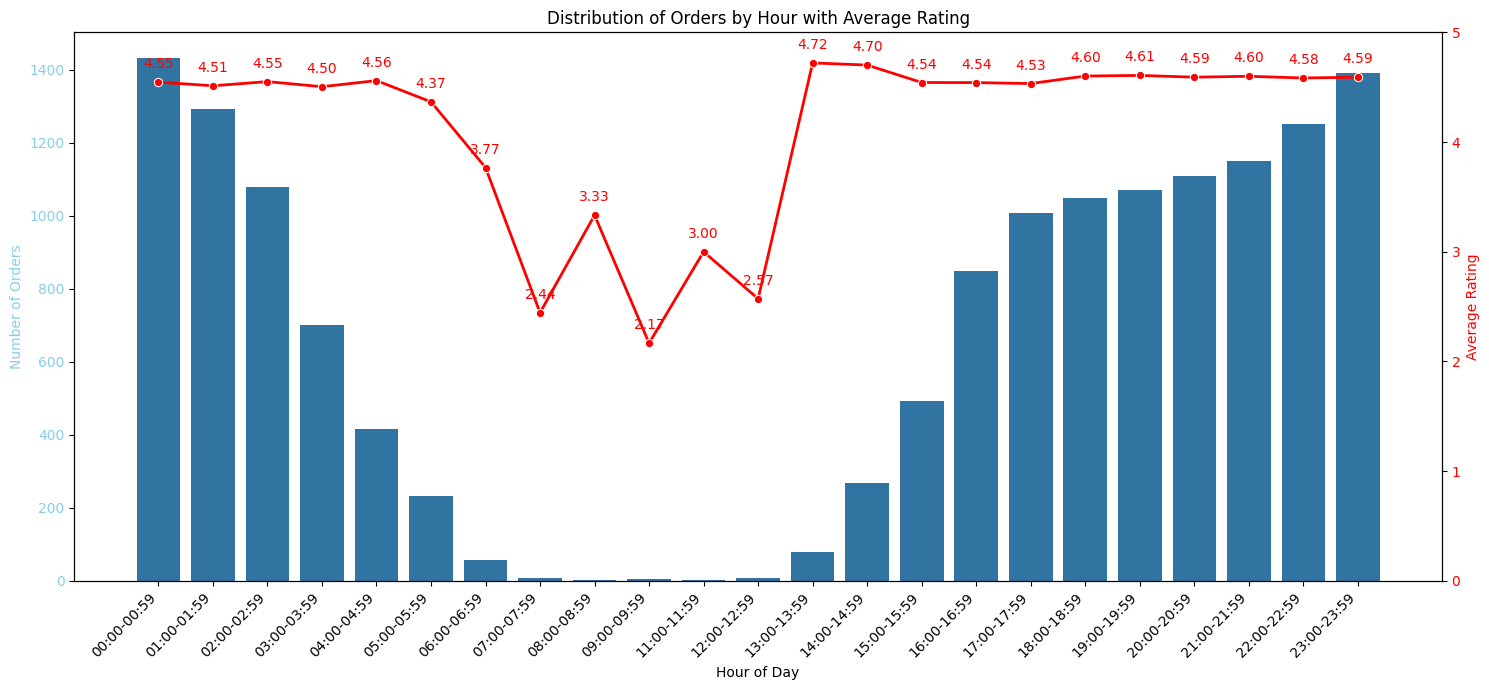

In [72]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Orders_Count as bar chart on the primary y-axis
sns.barplot(x='Hour_Range', y='Orders_Count', data=hourly_metrics_df, ax=ax1)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Orders', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Distribution of Orders by Hour with Average Rating')
ax1.set_xticklabels(hourly_metrics_df['Hour_Range'], rotation=45, ha='right')

# Create a secondary y-axis for Average_Rating
ax2 = ax1.twinx()
# Plot Average_Rating as a line chart on the secondary y-axis
sns.lineplot(x='Hour_Range', y='Average_Rating', data=hourly_metrics_df, ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

# Add average rating labels to the line plot
for x_pos, y_pos in enumerate(hourly_metrics_df['Average_Rating']):
    ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom') # Adjust y_pos for label placement

plt.tight_layout()
plt.show()

可以看出，订单量本身和好评率关系不大，和时段有关系，清晨到上午这个时段的好评是最少的

##### Day-of-week

In [73]:
query_daily_metrics = """
SELECT
    STRFTIME('%w', REPLACE(REPLACE(`order delivery time`, ' UTC', ''), ' +0000', '')) AS Day_of_Week_Num, -- %w for weekday number (0=Sunday, 6=Saturday)
    COUNT(`order id`) AS Orders_Count,
    AVG(`customer order rating`) AS Average_Rating
FROM
    customer_data
GROUP BY
    Day_of_Week_Num
ORDER BY
    Day_of_Week_Num;
"""
daily_metrics_df = pd.read_sql(query_daily_metrics, engine)

# Map day numbers to human-readable day names
day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
# Convert Day_of_Week_Num to integer type before mapping
daily_metrics_df['Day_of_Week'] = daily_metrics_df['Day_of_Week_Num'].astype(int).map(day_names)

display(daily_metrics_df[['Day_of_Week', 'Orders_Count', 'Average_Rating']])

,Day_of_Week,Orders_Count,Average_Rating
0,Sunday,2588,4.528594
1,Monday,2381,4.517010
2,Tuesday,2051,4.533398
3,Wednesday,1729,4.510700
4,Thursday,1877,4.552477
5,Friday,2072,4.641892
6,Saturday,2259,4.622399


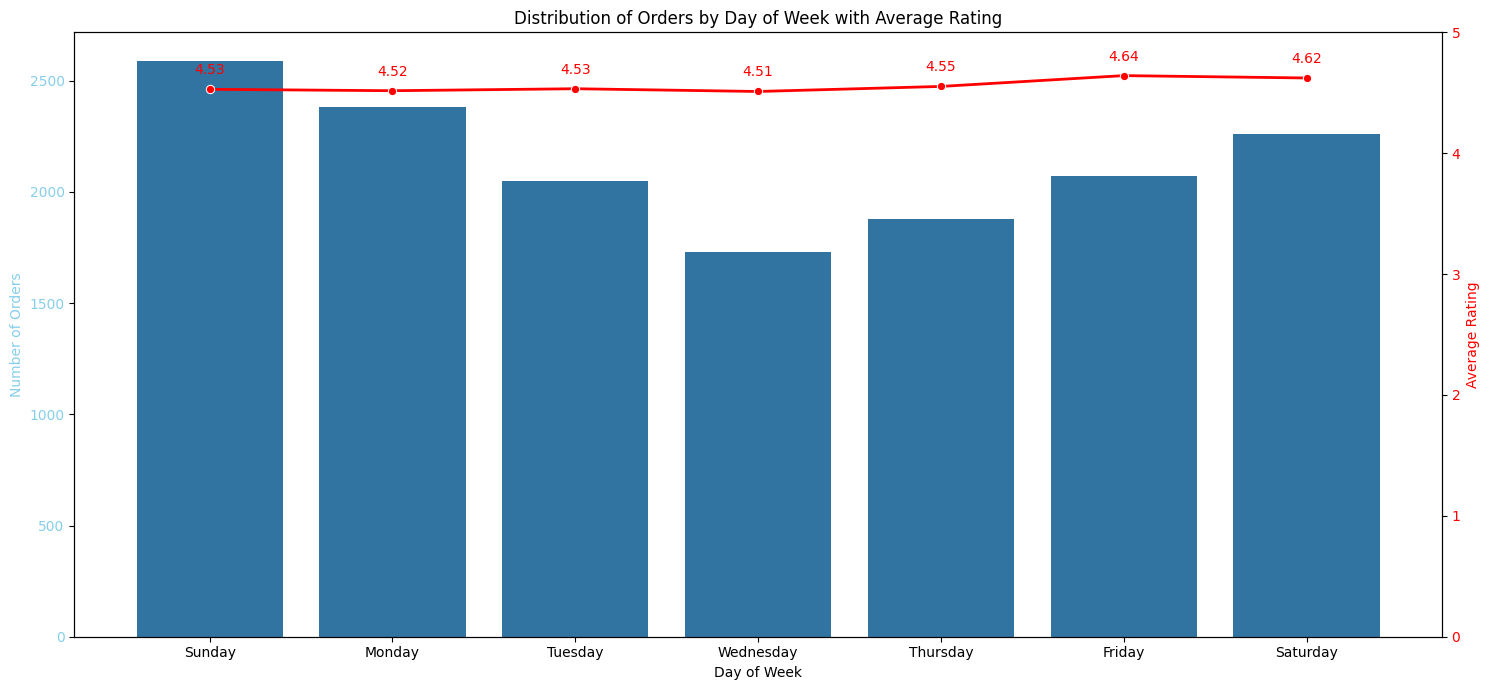

In [74]:
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot Orders_Count as bar chart on the primary y-axis
sns.barplot(x='Day_of_Week', y='Orders_Count', data=daily_metrics_df, ax=ax1)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Number of Orders', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Distribution of Orders by Day of Week with Average Rating')
# ax1.set_xticklabels(daily_metrics_df['Day_of_Week'], rotation=45, ha='right') # No need to rotate if days are short

# Create a secondary y-axis for Average_Rating
ax2 = ax1.twinx()
# Plot Average_Rating as a line chart on the secondary y-axis
sns.lineplot(x='Day_of_Week', y='Average_Rating', data=daily_metrics_df, ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Average Rating', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

# Add average rating labels to the line plot
for x_pos, y_pos in enumerate(daily_metrics_df['Average_Rating']):
    ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom') # Adjust y_pos for label placement

plt.tight_layout()
plt.show()

订单数量：按周来划分的话，呈现以周中为最低，两边渐渐增长的趋势
rating差别不大

## Business Insights
### 以上数据的重点
1. 各地区之间的评分差别不是很大，Chi的总体发挥最好（评分高+订单多）
2. 5星好评率77.5% -> 并不算高  
差评率（<= 3星）-> 约等于6%
3. 投诉原因：
  - 92.7%无事发生
  - 产品问题：wrong item + damaged/spoiled + item missing -> 占比5.7%  
  - 服务问题：poor service + poor replacement -> 1.2%  
  - logistical issue: item charged incoorectly -> 0.1%  
  由此可知，重点首先应放在提升产品本身上，也就是和商家之间的沟通和选择更优质的商家
4. damaged, missing, poor service做的特别不好容易导致低评，对这些部分要尤其注意，应第一时间改进，特别是poor service这种我方比较可控的。
5. 按小时来划分：订单量本身和好评率关系不大，和时段有关系，清晨到上午这个时段的均评是最低的 -> 可以进一步探究原因，同时知道每日的peak hour
6. 按周来划分：订单数量呈现以周中为最低，两边渐渐增长的趋势，rating差别不大 -> 初步得知staff allocation应放在周首尾

‼️**疑点**：  
Order ID重复的次数越多，评分越低

或许是因为我理解错了order id的意思？order id的意思是每一单，所以count对应的是每一单的物品数量而非一个月同一个人消费的总次数？

### 挑出我们可以解决的问题（staffing、report issues），提出解决方案
1. 优化人员配置，节约人力成本：staffing，按具体到每周的每天的24小时来细化peak hour
2. 提升客户满意度（data-driven CX strategy）：根据地区进一步细化每个地区的核心低评type
3. 根据已有的数据做一个简易的 rating regression
4. 提出下一步数据搜集的建议


### 心得：
合理的slice and dice，从大的现象来发现问题，并不断细化拆解成可以解决的小问题。

## Staff Allocation
看一下每周每天的不同时段对staff的需求

In [75]:
# Extract the day of the week and hour of the day from the 'order delivery time' column and calculate the number of orders and average rating for each unique day-hour combination.
query_daily_hourly_metrics = """
SELECT
    STRFTIME('%w', REPLACE(REPLACE(`order delivery time`, ' UTC', ''), ' +0000', '')) AS Day_of_Week_Num,
    STRFTIME('%H', REPLACE(REPLACE(`order delivery time`, ' UTC', ''), ' +0000', '')) AS Hour_of_Day,
    COUNT(`order id`) AS Orders_Count,
    AVG(`customer order rating`) AS Average_Rating
FROM
    customer_data
GROUP BY
    Day_of_Week_Num, Hour_of_Day
ORDER BY
    Day_of_Week_Num, Hour_of_Day;
"""
daily_hourly_metrics_df = pd.read_sql(query_daily_hourly_metrics, engine)
display(daily_hourly_metrics_df)

,Day_of_Week_Num,Hour_of_Day,Orders_Count,Average_Rating
0,0,00,190,4.584211
1,0,01,142,4.598592
2,0,02,148,4.445946
3,0,03,73,4.561644
4,0,04,58,4.431034
...,...,...,...,...
136,6,19,180,4.605556
137,6,20,190,4.663158
138,6,21,187,4.647059
139,6,22,188,4.739362


In [76]:
# Convert the numeric day of the week to human-readable names and the hour to a human-readable range
day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
daily_hourly_metrics_df['Day_of_Week'] = daily_hourly_metrics_df['Day_of_Week_Num'].astype(int).map(day_names)
daily_hourly_metrics_df['Hour_Range'] = daily_hourly_metrics_df['Hour_of_Day'].apply(lambda x: f"{x}:00-{int(x):02d}:59")

display(daily_hourly_metrics_df.head())

,Day_of_Week_Num,Hour_of_Day,Orders_Count,Average_Rating,Day_of_Week,Hour_Range
0,0,00,190,4.584211,Sunday,00:00-00:59
1,0,01,142,4.598592,Sunday,01:00-01:59
2,0,02,148,4.445946,Sunday,02:00-02:59
3,0,03,73,4.561644,Sunday,03:00-03:59
4,0,04,58,4.431034,Sunday,04:00-04:59


In [77]:
for day_num, day_name in day_names.items():
    daily_data = daily_hourly_metrics_df[daily_hourly_metrics_df['Day_of_Week_Num'] == str(day_num)]
    if not daily_data.empty:
        print(f"\n--- {day_name}'s Hourly Metrics ---")
        display(daily_data[['Hour_Range', 'Orders_Count', 'Average_Rating']])


--- Sunday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
0,00:00-00:59,190,4.584211
1,01:00-01:59,142,4.598592
2,02:00-02:59,148,4.445946
3,03:00-03:59,73,4.561644
4,04:00-04:59,58,4.431034
5,05:00-05:59,31,4.612903
6,06:00-06:59,9,4.000000
7,07:00-07:59,4,2.500000
8,08:00-08:59,2,4.000000
9,09:00-09:59,3,2.333333



--- Monday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
22,00:00-00:59,253,4.407115
23,01:00-01:59,227,4.295154
24,02:00-02:59,210,4.628571
25,03:00-03:59,125,4.328000
26,04:00-04:59,77,4.571429
27,05:00-05:59,44,4.318182
28,06:00-06:59,12,3.666667
29,13:00-13:59,13,4.923077
30,14:00-14:59,43,4.744186
31,15:00-15:59,92,4.456522



--- Tuesday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
40,00:00-00:59,211,4.606635
41,01:00-01:59,228,4.508772
42,02:00-02:59,204,4.460784
43,03:00-03:59,125,4.408000
44,04:00-04:59,74,4.432432
45,05:00-05:59,57,4.368421
46,06:00-06:59,9,3.444444
47,07:00-07:59,4,3.000000
48,13:00-13:59,9,4.555556
49,14:00-14:59,41,4.707317



--- Wednesday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
59,00:00-00:59,191,4.549738
60,01:00-01:59,158,4.512658
61,02:00-02:59,165,4.569697
62,03:00-03:59,117,4.581197
63,04:00-04:59,51,4.529412
64,05:00-05:59,27,4.333333
65,06:00-06:59,6,3.166667
66,07:00-07:59,1,0.000000
67,09:00-09:59,1,2.000000
68,12:00-12:59,2,3.500000



--- Thursday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
80,00:00-00:59,192,4.619792
81,01:00-01:59,187,4.438503
82,02:00-02:59,121,4.504132
83,03:00-03:59,86,4.534884
84,04:00-04:59,47,4.808511
85,05:00-05:59,27,3.851852
86,06:00-06:59,9,3.666667
87,08:00-08:59,1,2.000000
88,09:00-09:59,1,3.000000
89,12:00-12:59,1,4.000000



--- Friday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
101,00:00-00:59,188,4.569149
102,01:00-01:59,165,4.775758
103,02:00-02:59,129,4.666667
104,03:00-03:59,90,4.733333
105,04:00-04:59,53,4.566038
106,05:00-05:59,27,4.407407
107,06:00-06:59,8,4.500000
108,11:00-11:59,1,2.000000
109,12:00-12:59,2,2.000000
110,13:00-13:59,11,4.545455



--- Saturday's Hourly Metrics ---


,Hour_Range,Orders_Count,Average_Rating
121,00:00-00:59,206,4.529126
122,01:00-01:59,186,4.559140
123,02:00-02:59,103,4.601942
124,03:00-03:59,84,4.476190
125,04:00-04:59,56,4.660714
126,05:00-05:59,19,4.789474
127,06:00-06:59,3,4.000000
128,09:00-09:59,1,1.000000
129,11:00-11:59,2,3.500000
130,13:00-13:59,18,4.722222


不同地区还有时差问题，所以这个数据

Visualize hourly metrics for each day of the week, with 'Orders_Count' as a bar chart and 'Average_Rating' as a line chart against 'Hour_Range'.

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


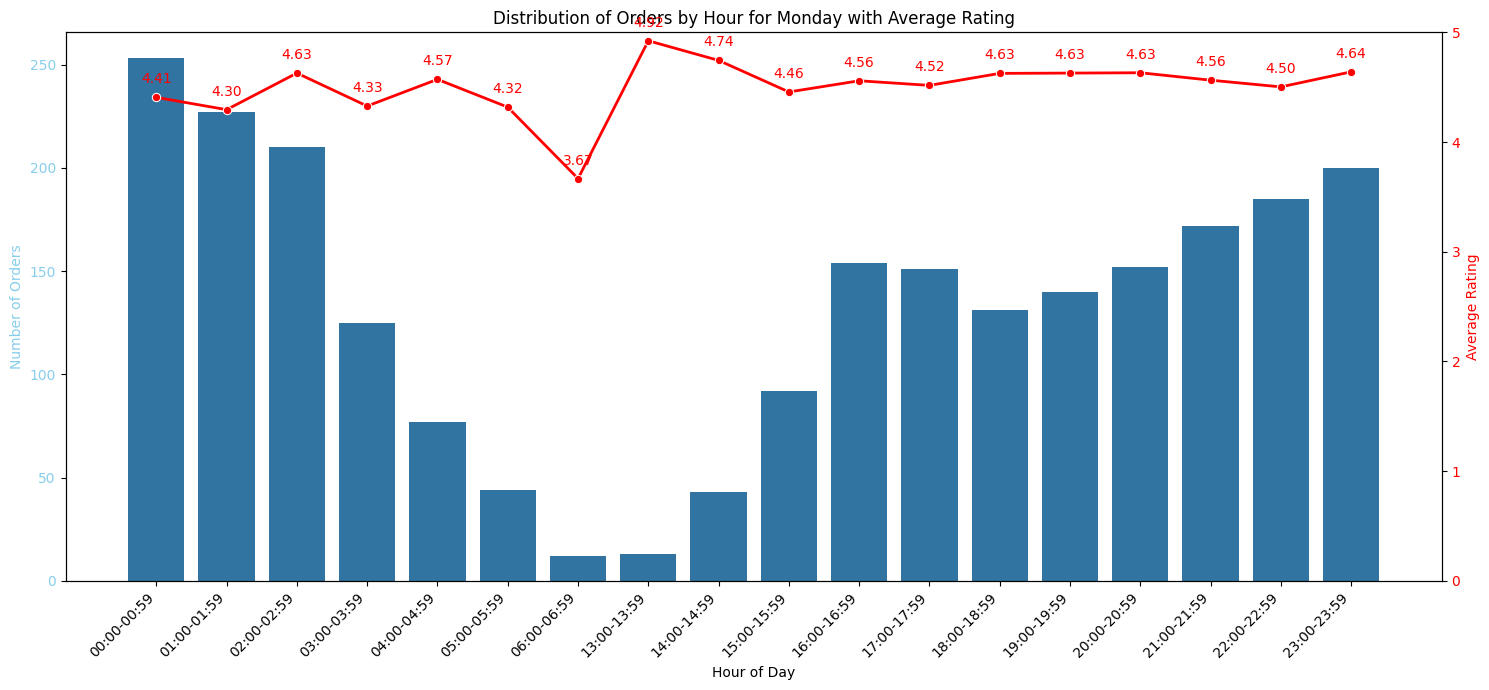

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


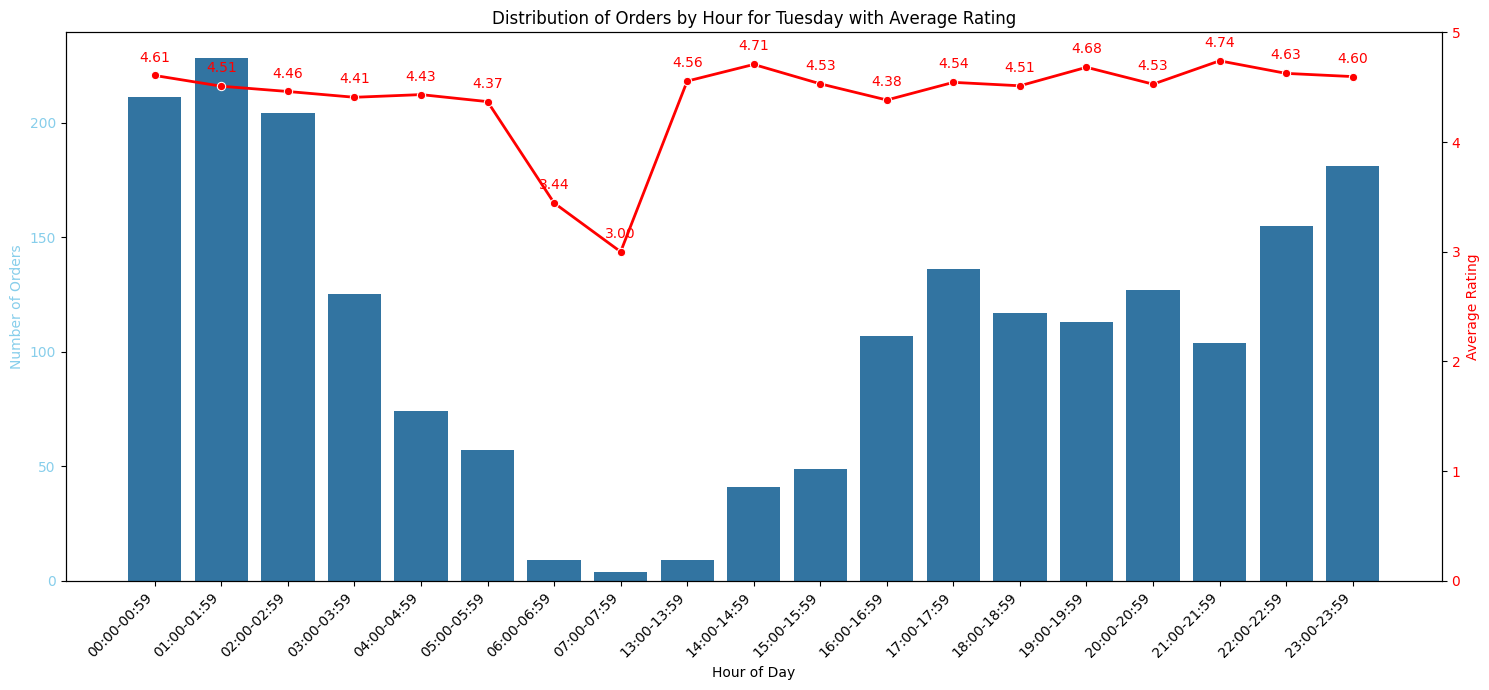

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


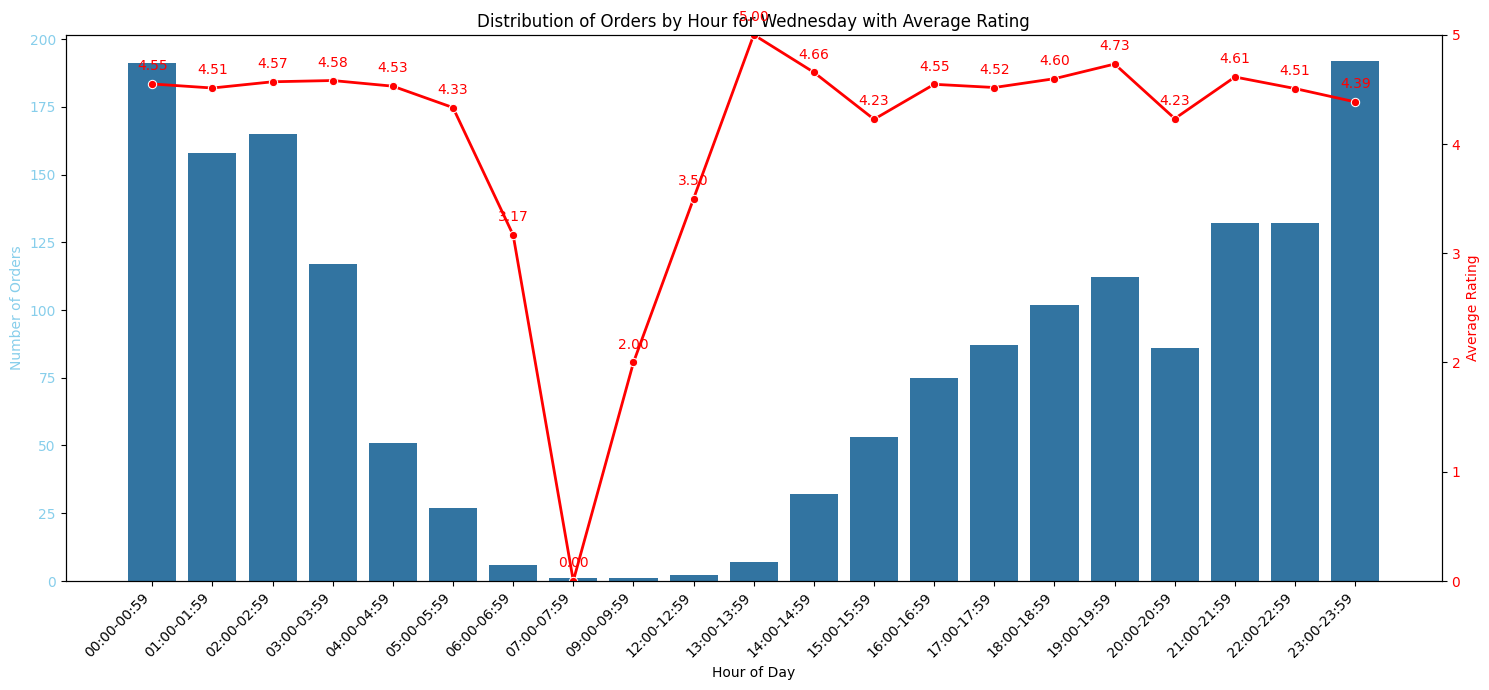

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


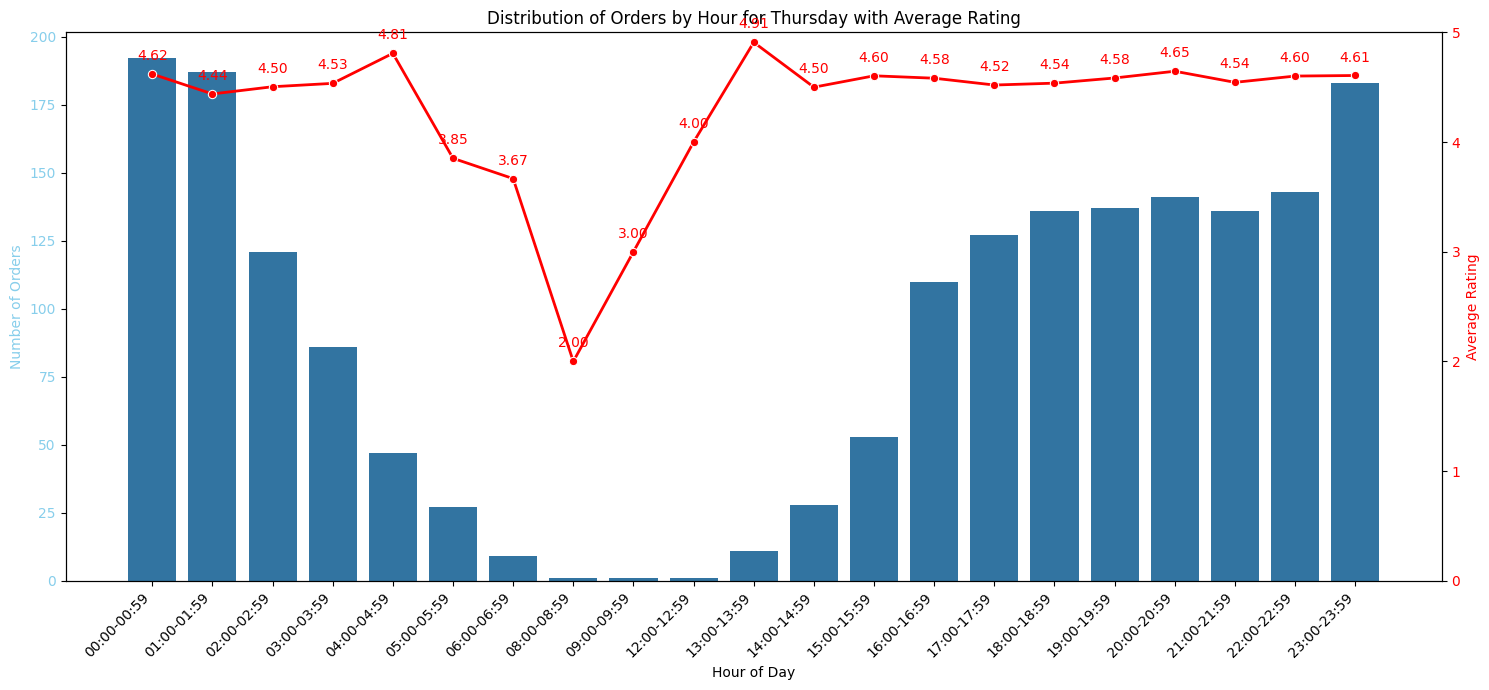

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


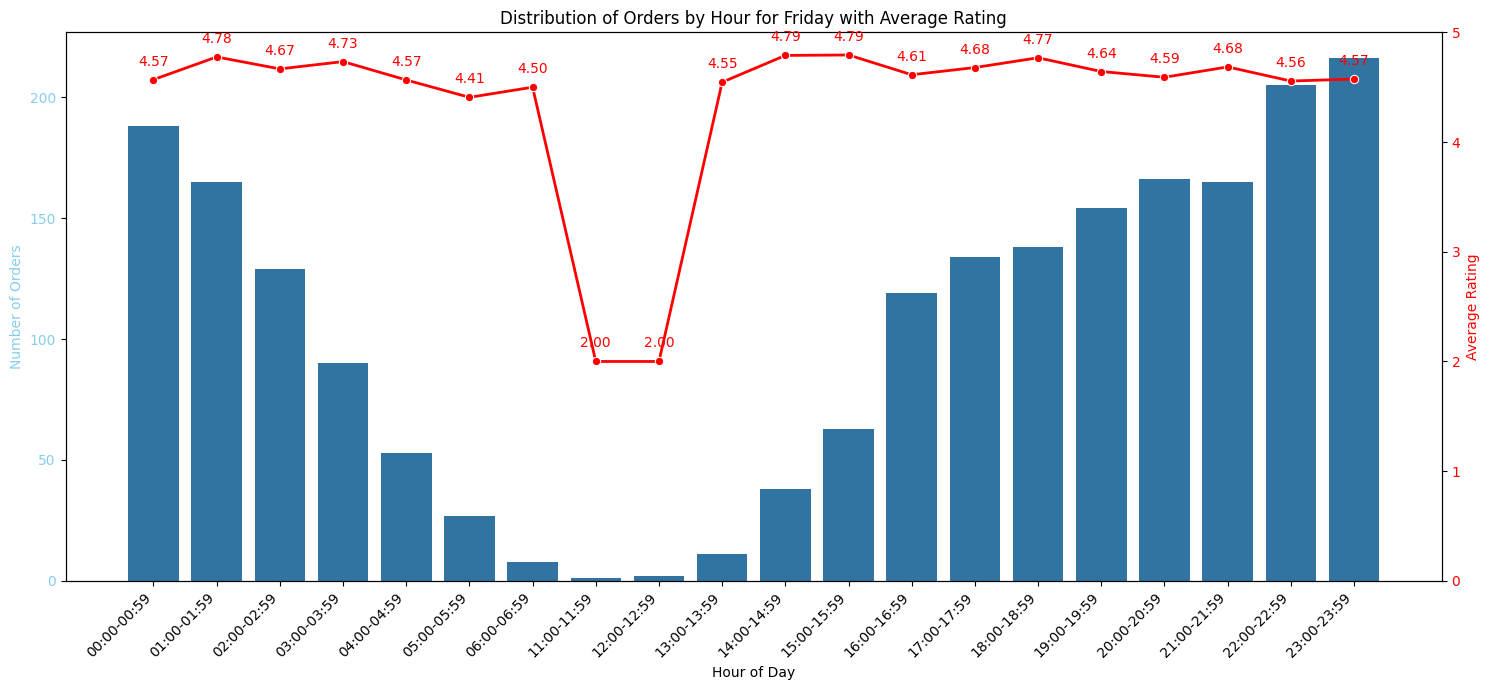

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


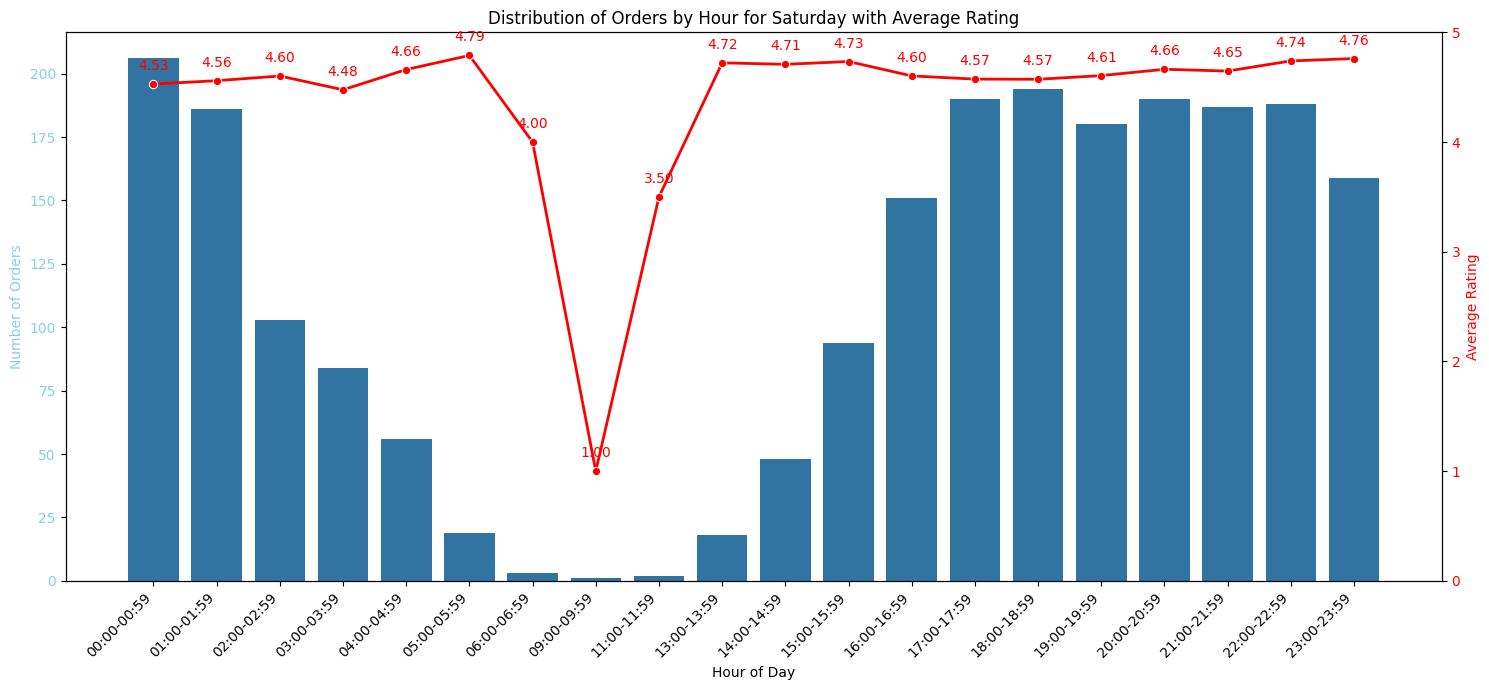

/tmp/ipython-input-2499226259.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')


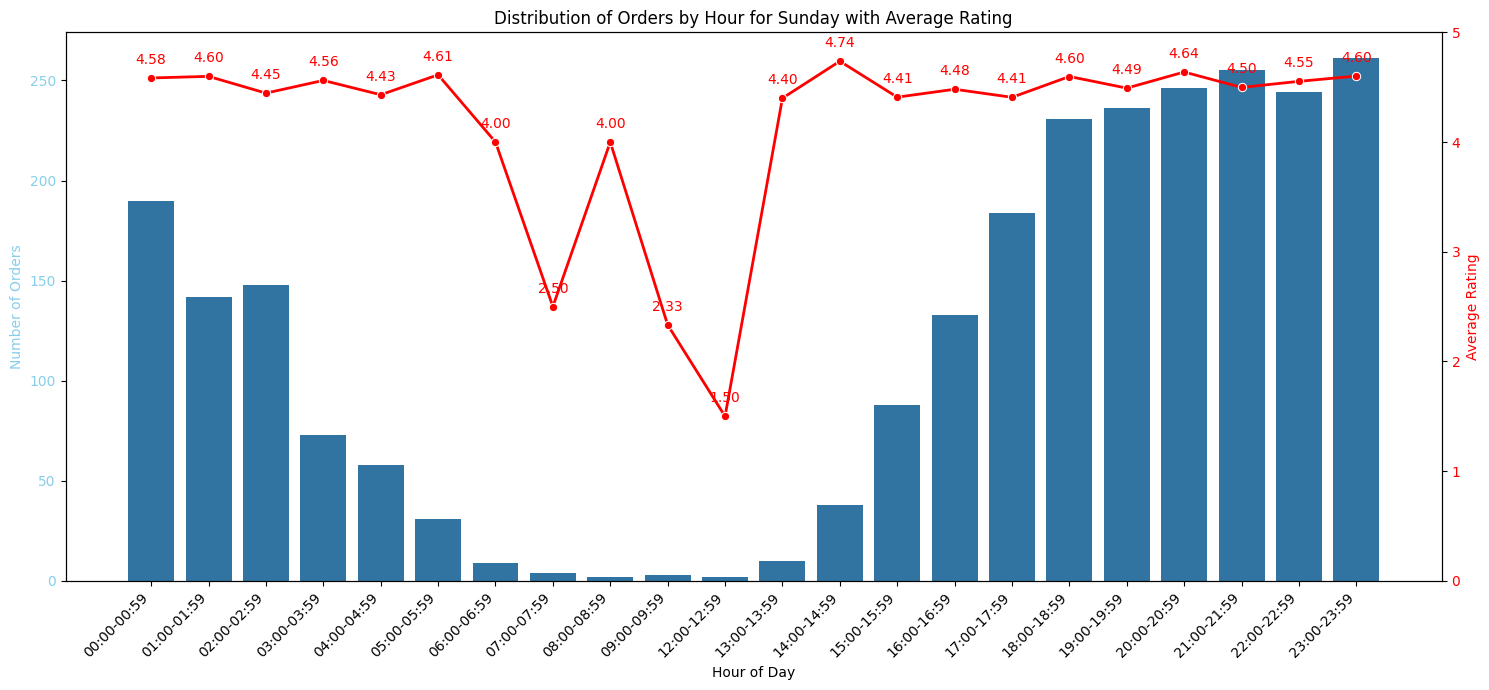

In [78]:
# Define the desired order of days for plotting
ordered_day_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 0: 'Sunday'}

for day_num, day_name in ordered_day_names.items():
    daily_data = daily_hourly_metrics_df[daily_hourly_metrics_df['Day_of_Week_Num'] == str(day_num)]

    if not daily_data.empty:
        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Plot Orders_Count as bar chart on the primary y-axis
        sns.barplot(x='Hour_Range', y='Orders_Count', data=daily_data, ax=ax1, color='skyblue')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Number of Orders', color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')
        ax1.set_title(f'Distribution of Orders by Hour for {day_name} with Average Rating')
        ax1.set_xticklabels(daily_data['Hour_Range'], rotation=45, ha='right')

        # Create a secondary y-axis for Average_Rating
        ax2 = ax1.twinx()
        # Plot Average_Rating as a line chart on the secondary y-axis
        sns.lineplot(x='Hour_Range', y='Average_Rating', data=daily_data, ax=ax2, color='red', marker='o', linewidth=2)
        ax2.set_ylabel('Average Rating', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

        # Add average rating labels to the line plot
        for x_pos, y_pos in enumerate(daily_data['Average_Rating']):
            ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom') # Adjust y_pos for label placement

        plt.tight_layout()
        plt.show()

从图上可以得出，其实每天的趋势是差不多的，因为样本量不大，所以低需求+低评那段的数据本身差别也可以忽略不计。  
‼️这部分说明需要使用统计的方法去论证么？还是在实际过程中无人在意，说最后的结论就好？

既然每天的差别不大，那我就还是用整体的数据（不划分天）来做一个Peak hour的分析（增大样本），同时做一个地区的划分（因为会有时差的问题，不同地区的订单量又不一样，如果拿同一套底层数据做分析，那时间的peak可以确定，但人数会有差）

### hourly order counts per day and average ratings for each region:

#### Calculate_Average_Orders_Per_Day_for_Region_Hourly_Data


In [79]:
df['order delivery time'] = pd.to_datetime(df['order delivery time'], errors='coerce', utc=True)
unique_days = df['order delivery time'].dt.date.nunique()
print(f"Number of unique days in the dataset: {unique_days}")

Number of unique days in the dataset: 33


In [80]:
regional_hourly_metrics_df['Average_Orders_Per_Day'] = regional_hourly_metrics_df['Orders_Count'] / unique_days
display(regional_hourly_metrics_df.head())

,region,Hour_of_Day,Orders_Count,Average_Rating,Hour_Range,Average_Orders_Per_Day,Demand_Category
0,chi,00,706,4.696884,00:00-00:59,21.393939,High Demand
1,chi,01,546,4.626374,01:00-01:59,16.545455,High Demand
2,chi,02,369,4.636856,02:00-02:59,11.181818,Medium Demand
3,chi,03,98,4.765306,03:00-03:59,2.969697,Low Demand
4,chi,04,15,4.666667,04:00-04:59,0.454545,Low Demand


/tmp/ipython-input-1632879107.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(region_data['Hour_Range'], rotation=45, ha='right')


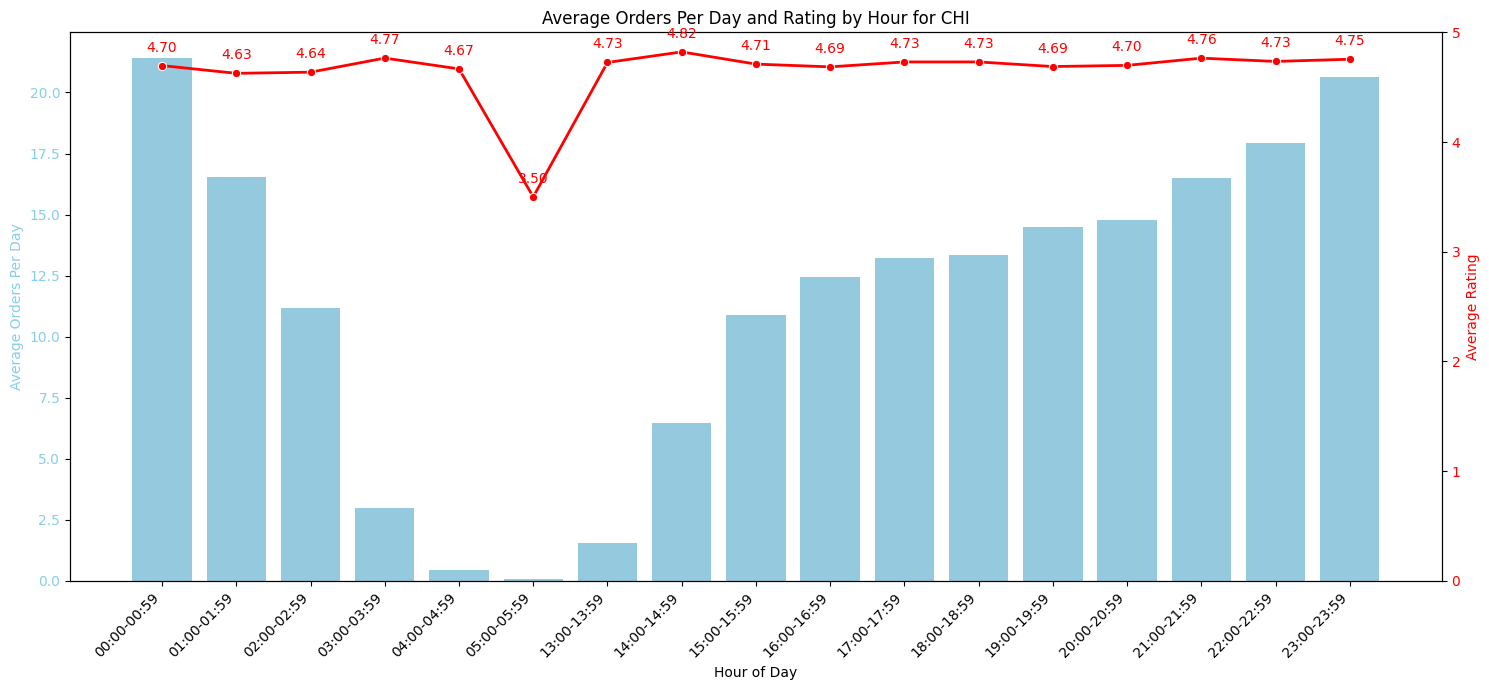

/tmp/ipython-input-1632879107.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(region_data['Hour_Range'], rotation=45, ha='right')


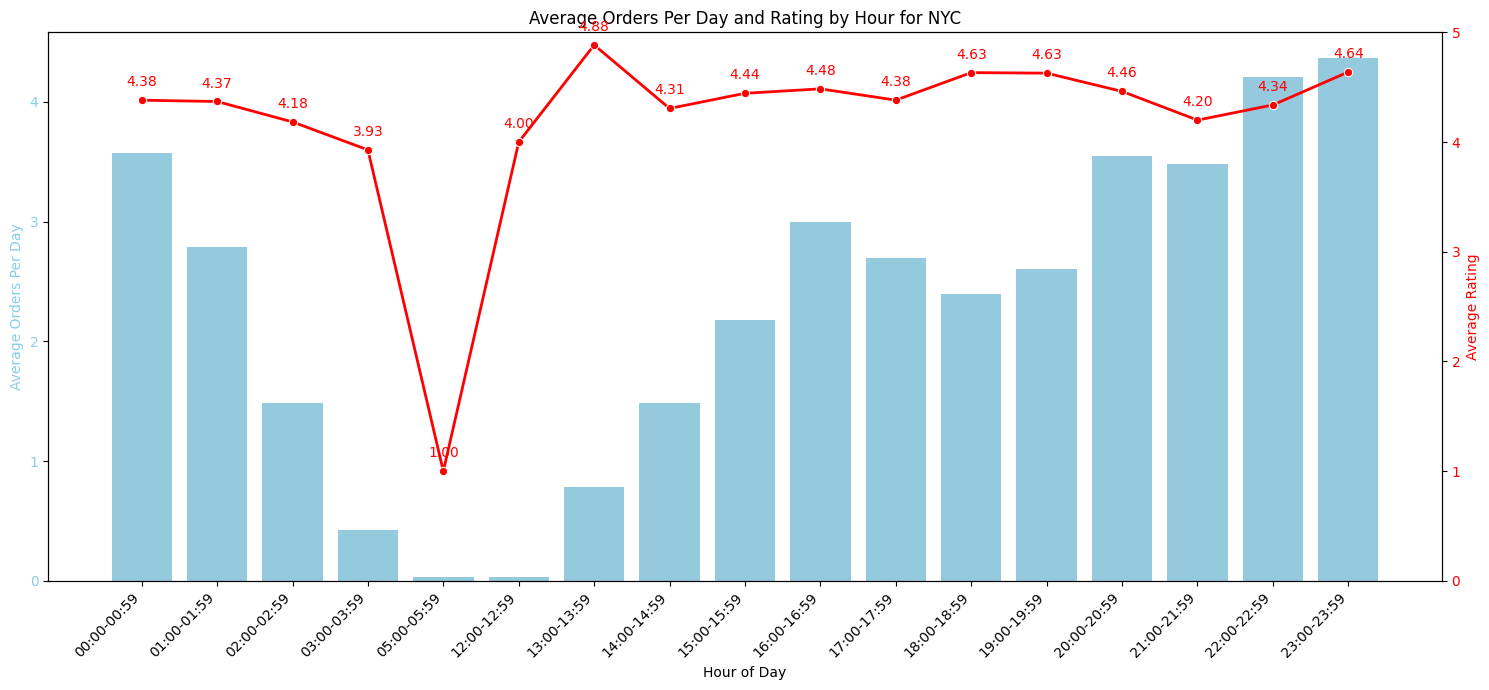

/tmp/ipython-input-1632879107.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(region_data['Hour_Range'], rotation=45, ha='right')


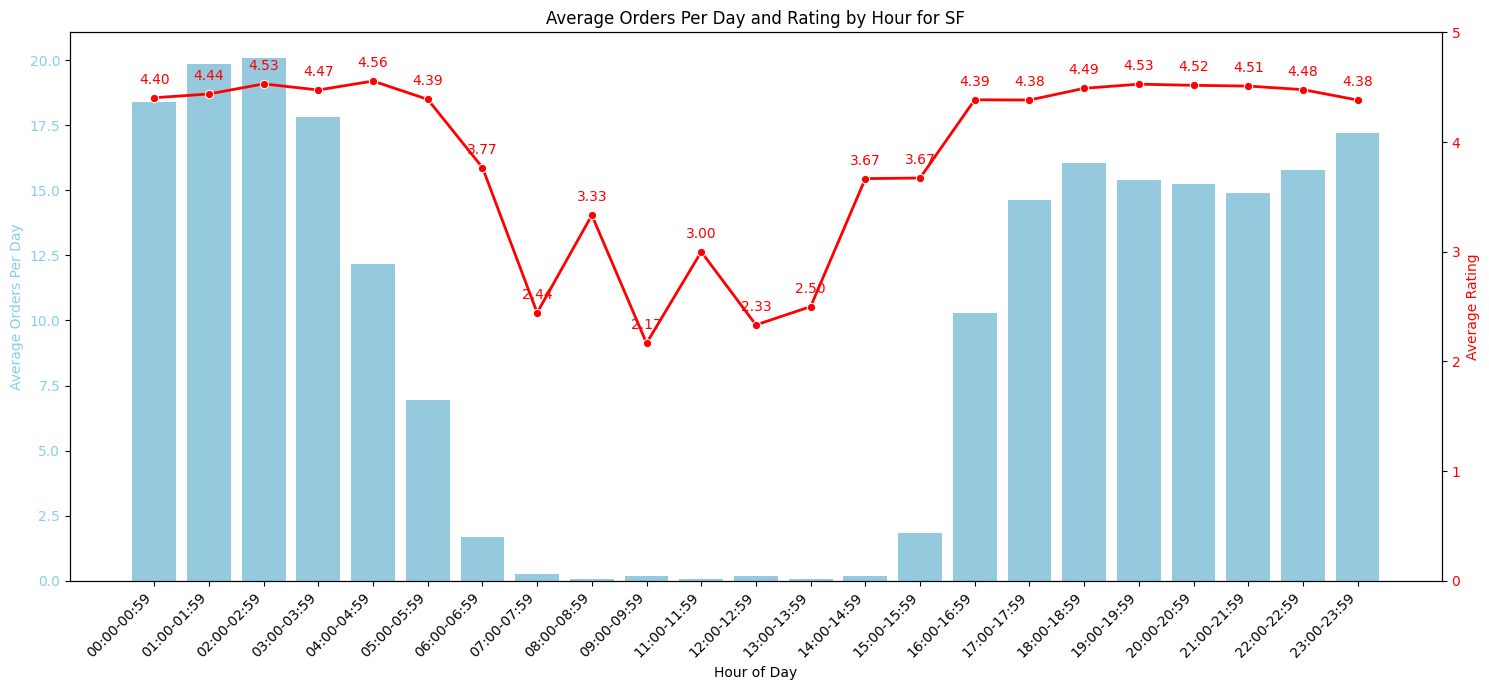

In [81]:
unique_regions = regional_hourly_metrics_df['region'].unique()

for region_name in unique_regions:
    region_data = regional_hourly_metrics_df[regional_hourly_metrics_df['region'] == region_name].copy()

    if not region_data.empty:
        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Plot Average_Orders_Per_Day as bar chart on the primary y-axis
        sns.barplot(x='Hour_Range', y='Average_Orders_Per_Day', data=region_data, ax=ax1, color='skyblue')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Average Orders Per Day', color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')
        ax1.set_title(f'Average Orders Per Day and Rating by Hour for {region_name.upper()}')
        ax1.set_xticklabels(region_data['Hour_Range'], rotation=45, ha='right')

        # Create a secondary y-axis for Average_Rating
        ax2 = ax1.twinx()
        # Plot Average_Rating as a line chart on the secondary y-axis
        sns.lineplot(x='Hour_Range', y='Average_Rating', data=region_data, ax=ax2, color='red', marker='o', linewidth=2)
        ax2.set_ylabel('Average Rating', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

        # Add average rating labels to the line plot
        for x_pos, y_pos in enumerate(region_data['Average_Rating']):
            ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom') # Adjust y_pos for label placement

        plt.tight_layout()
        plt.show()

- 小时订单<5，分类为低需求
- 5～15，中需求
- 大于15，高需求

此数据应根据公司的标准来划分

In [82]:
def categorize_demand(avg_orders):
    if avg_orders < 5:
        return 'Low Demand'
    elif 5 <= avg_orders <= 15:
        return 'Medium Demand'
    else:
        return 'High Demand'

unique_regions = regional_hourly_metrics_df['region'].unique()

for region_name in unique_regions:
    region_data = regional_hourly_metrics_df[regional_hourly_metrics_df['region'] == region_name].copy()
    region_data['Demand_Category'] = region_data['Average_Orders_Per_Day'].apply(categorize_demand)

    # Order by Average_Orders_Per_Day in descending order
    region_data_sorted = region_data.sort_values(by='Average_Orders_Per_Day', ascending=False)

    if not region_data_sorted.empty:
        print(f"\n--- Hourly Demand Categories for {region_name.upper()} (Ordered by Average Orders Per Day) ---")
        display(region_data_sorted[['Hour_Range', 'Average_Orders_Per_Day', 'Demand_Category']])


--- Hourly Demand Categories for CHI (Ordered by Average Orders Per Day) ---


,Hour_Range,Average_Orders_Per_Day,Demand_Category
0,00:00-00:59,21.393939,High Demand
16,23:00-23:59,20.636364,High Demand
15,22:00-22:59,17.939394,High Demand
1,01:00-01:59,16.545455,High Demand
14,21:00-21:59,16.484848,High Demand
13,20:00-20:59,14.787879,Medium Demand
12,19:00-19:59,14.484848,Medium Demand
11,18:00-18:59,13.363636,Medium Demand
10,17:00-17:59,13.242424,Medium Demand
9,16:00-16:59,12.424242,Medium Demand



--- Hourly Demand Categories for NYC (Ordered by Average Orders Per Day) ---


,Hour_Range,Average_Orders_Per_Day,Demand_Category
33,23:00-23:59,4.363636,Low Demand
32,22:00-22:59,4.212121,Low Demand
17,00:00-00:59,3.575758,Low Demand
30,20:00-20:59,3.545455,Low Demand
31,21:00-21:59,3.484848,Low Demand
26,16:00-16:59,3.000000,Low Demand
18,01:00-01:59,2.787879,Low Demand
27,17:00-17:59,2.696970,Low Demand
29,19:00-19:59,2.606061,Low Demand
28,18:00-18:59,2.393939,Low Demand



--- Hourly Demand Categories for SF (Ordered by Average Orders Per Day) ---


,Hour_Range,Average_Orders_Per_Day,Demand_Category
36,02:00-02:59,20.060606,High Demand
35,01:00-01:59,19.848485,High Demand
34,00:00-00:59,18.393939,High Demand
37,03:00-03:59,17.818182,High Demand
56,23:00-23:59,17.181818,High Demand
51,18:00-18:59,16.030303,High Demand
55,22:00-22:59,15.787879,High Demand
52,19:00-19:59,15.393939,High Demand
53,20:00-20:59,15.242424,High Demand
54,21:00-21:59,14.909091,Medium Demand


‼️以上数据如何可视化让看众可以轻松理解？

## 各地区低评的type，需要抓的重点

In [83]:
query_regional_issues = """
SELECT
    region,
    `type of issue reported` AS Issue_Type,
    COUNT(*) AS Issue_Count,
    AVG(`customer order rating`) AS Average_Rating
FROM
    customer_data
GROUP BY
    region, `type of issue reported`
ORDER BY
    region, Issue_Count DESC;
"""
regional_issue_ratings_df = pd.read_sql(query_regional_issues, engine)
display(regional_issue_ratings_df)

,region,Issue_Type,Issue_Count,Average_Rating
0,chi,None,6158,4.778987
1,chi,Damaged or spoiled,102,3.137255
2,chi,Wrong item,82,3.317073
3,chi,Item missing,49,3.224490
4,chi,Poor service,15,2.133333
5,chi,Item charged incorrectly,13,4.384615
6,chi,Other Order Issue,7,2.714286
7,chi,Poor replacement,4,2.500000
8,nyc,None,1168,4.594178
9,nyc,Damaged or spoiled,53,3.000000


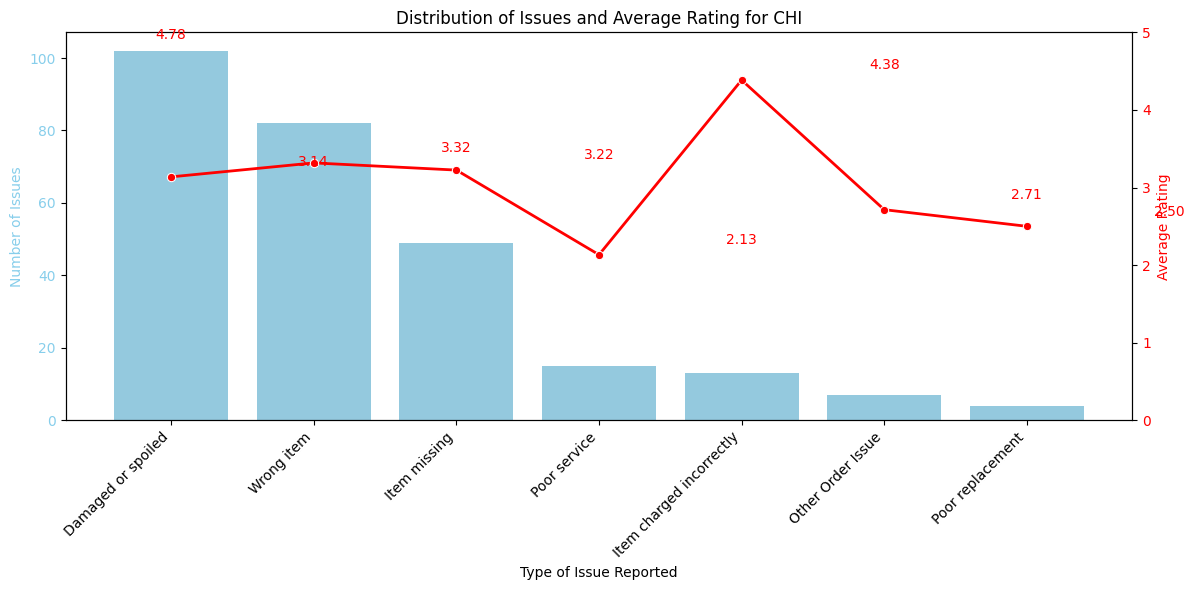

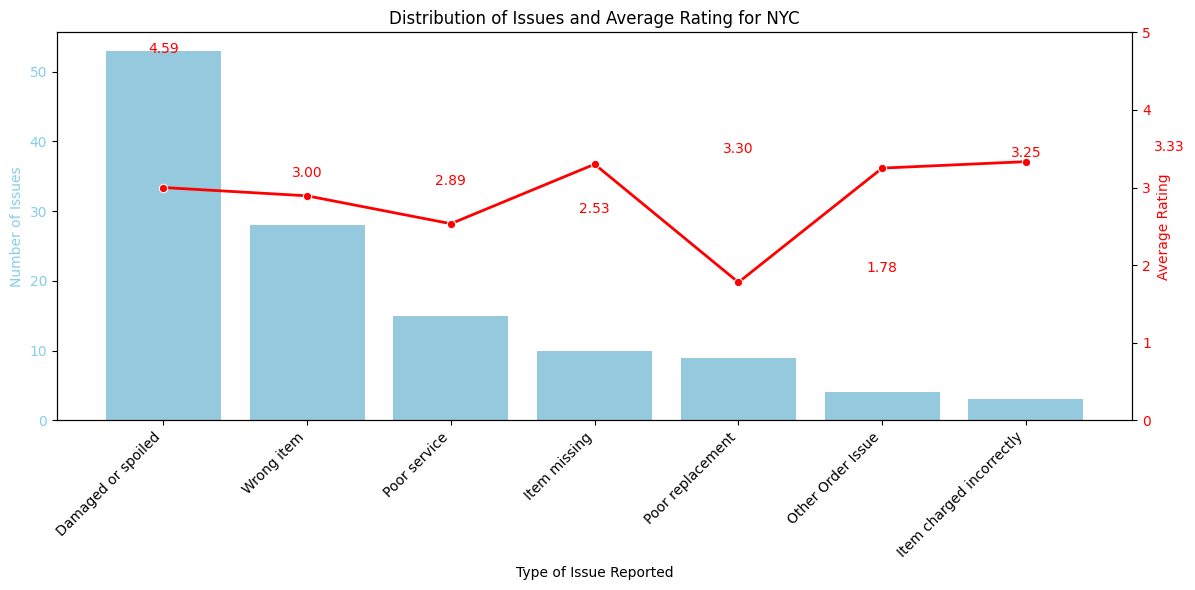

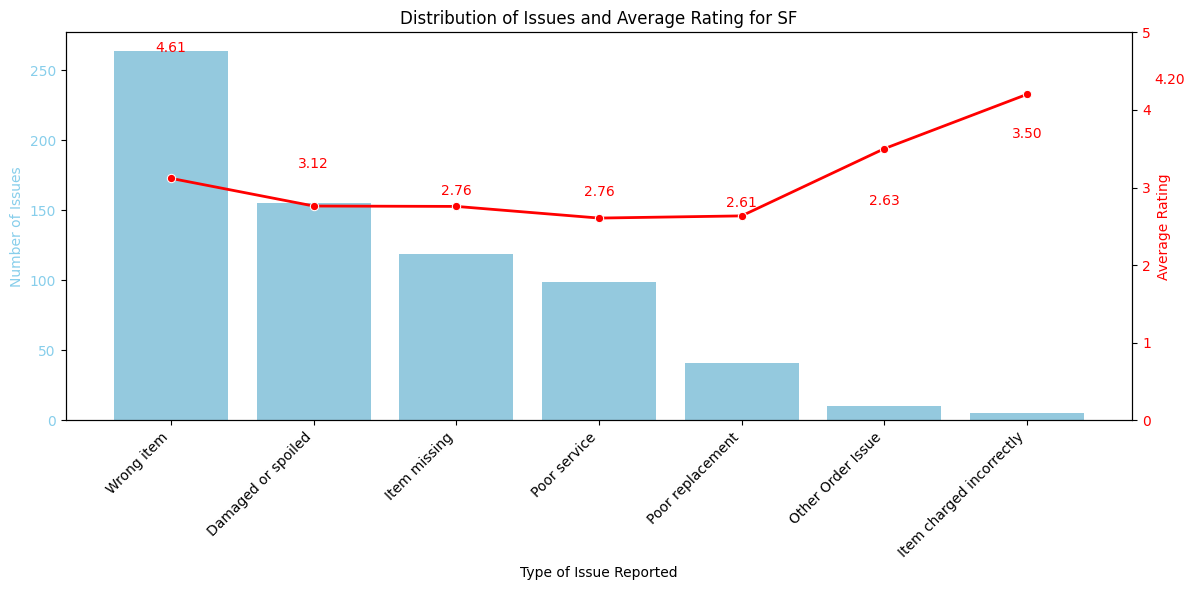

In [93]:
unique_regions = regional_issue_ratings_df['region'].unique()

for region_name in unique_regions:
    region_data = regional_issue_ratings_df[regional_issue_ratings_df['region'] == region_name].copy()

    # Filter out 'None' issue type for visualization to focus on reported issues
    issues_only_data = region_data[region_data['Issue_Type'] != 'None']

    if not issues_only_data.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot Issue_Count as bar chart on the primary y-axis
        sns.barplot(x='Issue_Type', y='Issue_Count', data=issues_only_data, ax=ax1, color='skyblue')
        ax1.set_xlabel('Type of Issue Reported')
        ax1.set_ylabel('Number of Issues', color='skyblue')
        ax1.tick_params(axis='y', labelcolor='skyblue')
        ax1.set_title(f'Distribution of Issues and Average Rating for {region_name.upper()}')

        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

        # Create a secondary y-axis for Average_Rating
        ax2 = ax1.twinx()
        # Plot Average_Rating as a line chart on the secondary y-axis
        sns.lineplot(x='Issue_Type', y='Average_Rating', data=issues_only_data, ax=ax2, color='red', marker='o', linewidth=2)
        ax2.set_ylabel('Average Rating', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylim(bottom=0, top=5) # Assuming ratings are 0-5

        # Add average rating labels to the line plot
        for x_pos, y_pos in enumerate(issues_only_data['Average_Rating']):
            ax2.text(x_pos, y_pos + 0.1, f'{y_pos:.2f}', color='red', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

总结：不同城市的主要问题稍微不一样，要分区注意

## Rating Regression
- IVs: type of issue, hour of day
- DV: Rating
- Control: region




In [102]:
import statsmodels.formula.api as smf
import pandas as pd

# Ensure order delivery time is in datetime format and extract hour
df['order delivery time'] = pd.to_datetime(df['order delivery time'], errors='coerce', utc=True)
df['hour'] = df['order delivery time'].dt.hour

# Define time block logic
def get_time_block(h):
    if 6 <= h < 11:
        return 'Morning'
    elif 11 <= h < 14:
        return 'Lunch'
    elif 14 <= h < 17:
        return 'Afternoon'
    elif 17 <= h < 21:
        return 'Dinner'
    else:
        return 'Late Night'

# Apply logic to create time_block column
df['time_block'] = df['hour'].apply(get_time_block)

# Define the regression formula with the new time_block variable
# We use Q() to handle column names with spaces
formula = 'Q("customer order rating") ~ C(Q("type of issue reported")) + C(time_block) + C(region)'

# Fit the OLS model
model = smf.ols(formula=formula, data=df).fit()

# Display the summary
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     Q("customer order rating")   R-squared:                       0.075
Model:                                    OLS   Adj. R-squared:                  0.065
Method:                         Least Squares   F-statistic:                     7.910
Date:                        Wed, 17 Dec 2025   Prob (F-statistic):           2.46e-13
Time:                                05:23:47   Log-Likelihood:                -1713.0
No. Observations:                        1087   AIC:                             3450.
Df Residuals:                            1075   BIC:                             3510.
Df Model:                                  11                                         
Covariance Type:                    nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---